Import necessary libraries

In [8]:
# Import necessary libraries

import matplotlib.pyplot as plt
import pandas as pd
 
import os

import numpy as np
import torch

from sklearn.preprocessing import MinMaxScaler


Read csv data using pandas and plot data 

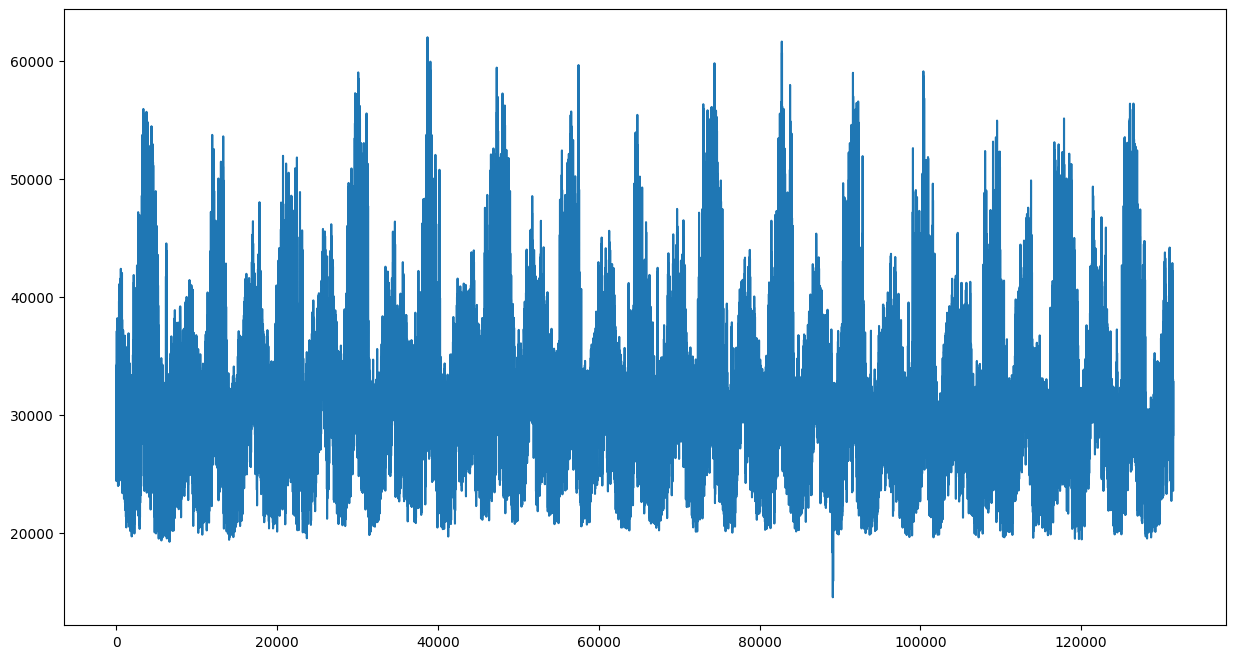

In [9]:
# read hourly water consumption data from water.csv file using pandas

df = pd.read_csv('./data/water_consumption.csv')
water_ts = df[["Consumption"]].values.reshape(-1, 1).astype('float32')
water_dt = df[["Datetime"]].values

plt.plot(water_ts)
plt.show()

Use sklearn's MinMaxScaler module to normalize water consumption values between 0 and 1

In [10]:
# essential normalization: use sklearn MinMaxScaler to adjust data values to [0,1]
scaler = MinMaxScaler(feature_range=(0,1))
# scaling dataset
scaled_water_ts = scaler.fit_transform(water_ts)
print(water_ts[:5])
print(scaled_water_ts[:5])

[[26498.]
 [25147.]
 [24574.]
 [24393.]
 [24860.]]
[[0.2518487 ]
 [0.22338563]
 [0.2113136 ]
 [0.20750028]
 [0.2173391 ]]


Daily and weekly water consumption plots w.r.t Date indices

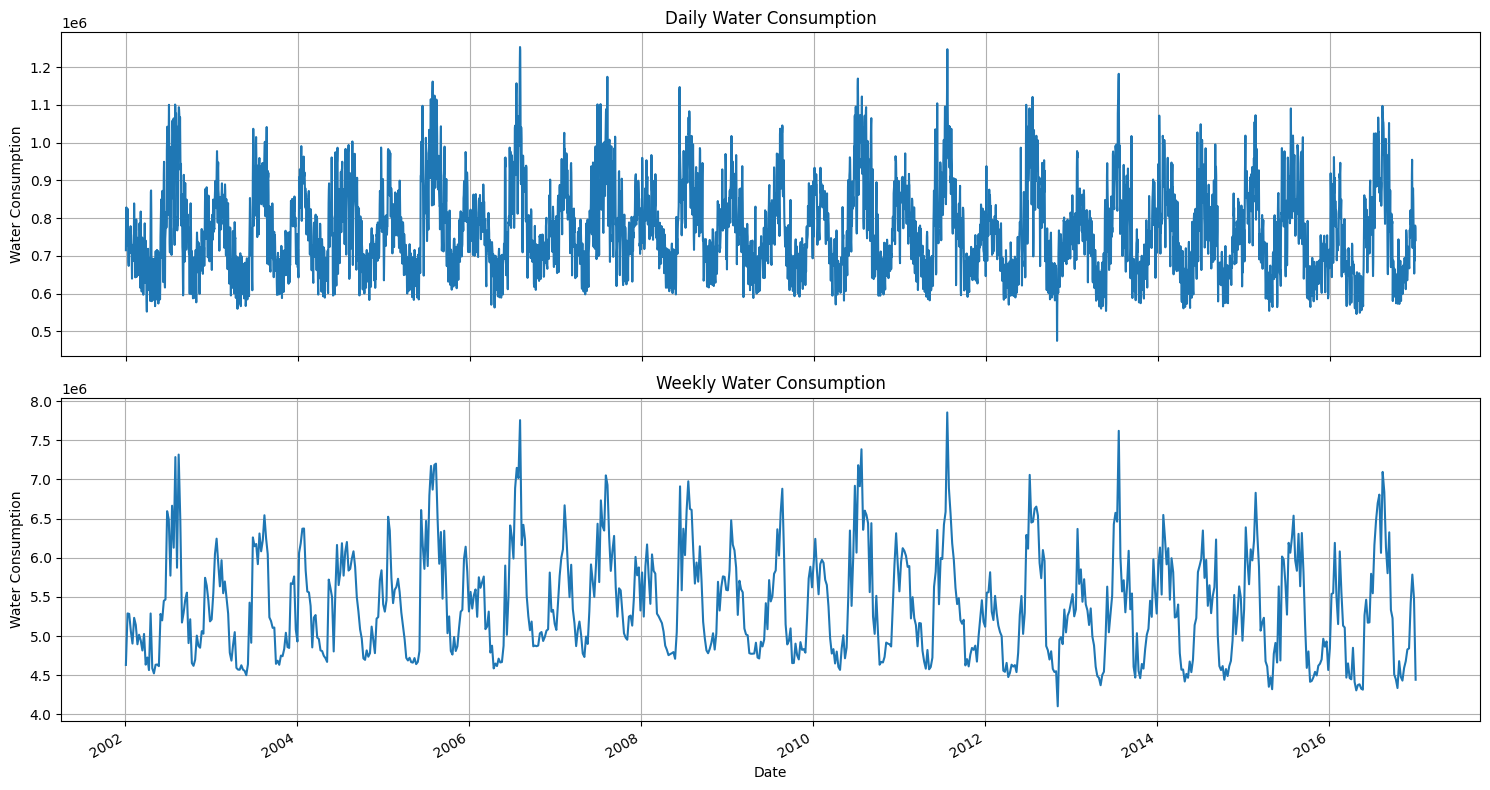

In [11]:
# convert timestamp column to a datetime object
df['Datetime'] = pd.to_datetime(df['Datetime'])

# set the 'timestamp' column as the index
df.set_index('Datetime', inplace=True)

# Resample the data to calculate daily and weekly consumption
daily_water_consumption = df['Consumption'].resample('D').sum()
weekly_water_consumption = df['Consumption'].resample('W').sum()

water_ts_weekly = weekly_water_consumption.values.reshape(-1, 1).astype('float32')
water_ts_daily = daily_water_consumption.values.reshape(-1, 1).astype('float32')

# Create subplots for daily and weekly consumption
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))

# plot of daily water consumption
ax1.plot(daily_water_consumption.index, daily_water_consumption.values)
ax1.set_title('Daily Water Consumption')
ax1.set_xlabel('Date')
ax1.set_ylabel('Water Consumption')
ax1.grid(True)

# plot of weekly water consumption
ax2.plot(weekly_water_consumption.index, weekly_water_consumption.values)
ax2.set_title('Weekly Water Consumption')
ax2.set_xlabel('Date')
ax2.set_ylabel('Water Consumption')
ax2.grid(True)

# format the x-axis date labels for better readability (optional)
fig.autofmt_xdate()

# Show the plots
plt.tight_layout()
plt.show()

Using statsmodel library perform decomposition to the time series data to extract trend, seasonality and noise.
The first plot shows the original data

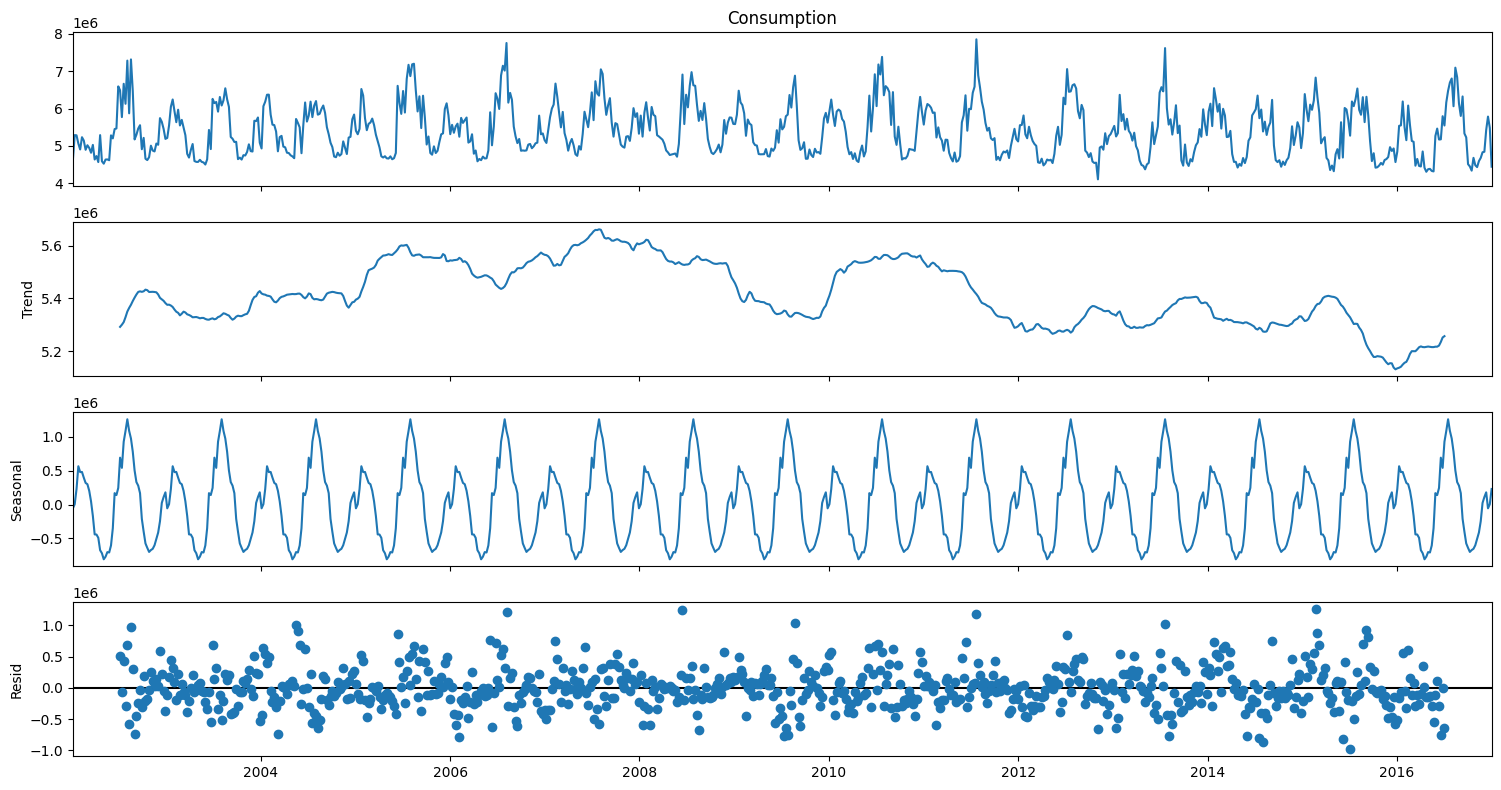

In [12]:
# visualize weekly data decomposition, that is seasonality, trend, noise
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8

decomposition = sm.tsa.seasonal_decompose( weekly_water_consumption, model='additive')
fig = decomposition.plot()
plt.show()

In [ ]:
Keep daily (as the sum of hourly data) water consumption data to use them and normalize them

In [13]:
water_consumption_per_week = weekly_water_consumption.tolist()
print(len(weekly_water_consumption))
water_consumption_per_day = daily_water_consumption.tolist()
print(len(daily_water_consumption))

# essential normalization: use sklearn MinMaxScaler to adjust data values to [0,1]
scaler = MinMaxScaler(feature_range=(0,1))
# scaling dataset
scaled_water_ts = scaler.fit_transform(water_ts_daily)
print(water_consumption_per_week[:5])
print(scaled_water_ts[:5])

783
5479
[4632079.0, 5289881.0, 5284084.0, 5063777.0, 4905010.0]
[[0.30857742]
 [0.44646168]
 [0.45417356]
 [0.42963886]
 [0.32765937]]


Create two years time series sequences and their corresponding values in a time-slide window manner

In [14]:
# create time-series sequences and values
ts_length = 365*2 # 365*=730 days = two years  
ts_seqs, ts_values = [], []
for i in range(len(scaled_water_ts) - ts_length):
	ts_seqs.append(scaled_water_ts[i:i+ts_length])
	ts_values.append(scaled_water_ts[i+ts_length:i+ts_length+1])



Split data to train(80%), val(10%), test(10%)

In [16]:
# split dataset to train, validation, test. use 80% for training, 10% for validation, 10% for testing
ts_seqs_train, ts_seqs_val, ts_seqs_test = np.array(ts_seqs[:int(.8*len(ts_seqs))]), np.array(ts_seqs[int(.8*len(ts_seqs)):-ts_length]), np.array(ts_seqs[-ts_length:]) 
ts_values_train, ts_values_val, ts_values_test = np.array(ts_values[:int(.8*len(ts_values))]), np.array(ts_values[int(.8*len(ts_values)):-ts_length]), np.array(ts_values[-ts_length:])



In [17]:
# convert numPy array data to tensors
ts_seqs_train, ts_values_train = torch.from_numpy(ts_seqs_train), torch.from_numpy(ts_values_train)
ts_seqs_val, ts_values_val = torch.from_numpy(ts_seqs_val), torch.from_numpy(ts_values_val)
ts_seqs_test, ts_values_test = torch.from_numpy(ts_seqs_test), torch.from_numpy(ts_values_test)


Load data to pytorch Dataloader

In [46]:
# create tensor dataset and give it as input to dataloader
batch_size = 16

# train data to dataloader
train_dataset = torch.utils.data.TensorDataset(ts_seqs_train, ts_values_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# train data to dataloader
val_dataset = torch.utils.data.TensorDataset(ts_seqs_val, ts_values_val)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
 
# test data to dataloader
test_dataset = torch.utils.data.TensorDataset(ts_seqs_test, ts_values_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

# # test data to dataloader
# test_dataset = torch.utils.data.TensorDataset(ts_seqs_test)
# test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

In [19]:
print(len(test_dataloader))

730


Define RNN class which contains the RNN attributes and information. Using a RNN model is a reasonable choice since we have to do with sequential data. RNNs can capture the time dependencies among an input data sequence through their hidden states.

In [20]:
# define RNN model class. since we have sequential data our choice would be a neural model capable to model the time relations,
# and RNN (LSTM or GRU) are ideal for such purposes 
import torch
import torch.nn as nn


class RNN_Module(nn.Module):

    def __init__(self, rnn_type, input_sz, hidden_sz, output_sz, number_of_layers, dropout_prob):
        super().__init__()

        self.num_of_layers = number_of_layers
        self.hidden_sz = hidden_sz
        self.rnn_type = rnn_type

        if rnn_type == 'LSTM':
            self.rnn = nn.LSTM( input_size=input_sz, hidden_size=hidden_sz, num_layers=number_of_layers, batch_first=True, dropout=dropout_prob)

        elif rnn_type == 'GRU':
            self.rnn = nn.GRU( input_size=input_sz, hidden_size=hidden_sz, num_layers=number_of_layers, batch_first=True, dropout=dropout_prob)


        self.fc = nn.Linear( hidden_sz, output_sz)
    

    def forward(self, x):
    
        if self.rnn_type=='LSTM':
            
            # Initializing hidden state for first input with zeros
            h0 = torch.zeros( self.num_of_layers, x.size(0), self.hidden_sz, device=x.device).requires_grad_()

            # Initializing cell state for first input with zeros
            c0 = torch.zeros( self.num_of_layers, x.size(0), self.hidden_sz, device=x.device).requires_grad_()

            # We need to detach as we are doing truncated backpropagation through time (BPTT)
            # If we don't, we'll backprop all the way to the start even after going through another batch
            # Forward propagation by passing in the input, hidden state, and cell state into the model
            out, (hn, cn) = self.rnn(x, (h0.detach(), c0.detach()))

            # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
            # so that it can fit into the fully connected layer
            out = out[:, -1, :]

            # Convert the final state to our desired output shape (batch_size, output_dim)
            out = self.fc(out)

            return out


        elif self.rnn_type=='GRU':

            # Initializing hidden state for first input with zeros
            h0 = torch.zeros( self.num_of_layers, x.size(0), self.hidden_sz, device=x.device).requires_grad_()

            # Forward propagation by passing in the input and hidden state into the model
            out, _ = self.rnn(x, h0.detach())

            # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
            # so that it can fit into the fully connected layer
            out = out[:, -1, :]

            # Convert the final state to our desired output shape (batch_size, output_dim)
            out = self.fc(out)

            return out







Set some model parameters and initialize the model

In [21]:
# define model parameters
input_size = 1
rnn_type = 'LSTM'
num_layers = 2
hidden_size = 64
output_size = 1
dropout_prob = 0.15

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

# initialize rnn model
#model = AttentionRNN_Module( rnn_type, input_size, hidden_size, output_size, num_layers, ts_length, dropout_prob)#.to(device)
model = RNN_Module( rnn_type, input_size, hidden_size, output_size, num_layers, dropout_prob).to(device)


In [22]:
# create dir (if does not exist) to save model training parameters checkpoints
if not os.path.exists('./model_checkpoints/'):
	os.mkdir('./model_checkpoints/')


There are two checkpoint functions, one to save the model's state dict and another one to load it.

In [23]:
# save and load model checkpoints functions

import torch
import io

def save_checkpoint( epoch, model, optimizer, vlosses, tlosses):

	state = {	'epoch': epoch, 'model_state_dict': model.state_dict(),
				'optimizer': optimizer.state_dict(), 'val_losses': vlosses, 'train_losses': tlosses}
	torch.save( state, './model_checkpoints/rnn_model_epoch' + str(epoch) + '_.pth' )


def load_checkpoint( epoch, model, optimizer):
  
	check_path = './model_checkpoints/rnn_model_epoch' + str(epoch) + '_.pth'
	with open(check_path, 'rb') as f:
		buffer = io.BytesIO(f.read())
	checkpoint = torch.load(buffer)  
	model.load_state_dict(checkpoint['model_state_dict'])
	optimizer.load_state_dict(checkpoint['optimizer'])
    
	print("\n Model Checkpoint of Epoch " + str(epoch) + " loaded!")
    
    
	return optimizer, model



The training (and validation) function. During training loss and accuracy are kept in the corresponding lists. By the end of each epoch the model's state dict is saved. When training has ended the model's state dict of the minimum validation loss epoch is loaded. Of course at every validation epoch no gradient is backpropagated and no parameter is updated. 

In [24]:
def train_it( model, train_dloader, val_dloader, num_epochs):


	model.train()

	# MSE loss function
	loss_func = torch.nn.MSELoss()
	# adam optimizer
	optimizer = torch.optim.Adam( model.parameters(), lr = .0001, weight_decay = 1e-8)


	epoch = 1
	continueTraining = True
	
	train_losses, val_losses = [], []
	train_accs, val_accs = [], []    
	#while continueTraining:
	while epoch < num_epochs:
		
		model.train()

		train_loss = 0
		train_rmse = 0

		for X_batch, y_batch in train_dloader:

			X_batch = X_batch.to(device)
			y_batch = y_batch.to(device)
            
			y_pred = model(X_batch)

        	# loss computation
			loss = loss_func(y_pred, y_batch.squeeze(1))

        	# gradients are zeroed
			optimizer.zero_grad()

        	# gradient loss backpropagated
			loss.backward()

        	# update parameters
			optimizer.step()

			train_loss += loss.item()
			train_rmse += np.sqrt(loss.item())
    	
        # average training loss 
		avg_train_rmse = train_rmse / len(train_dloader)
		avg_train_loss = train_loss / len(train_dloader)
		train_losses.append(avg_train_loss)
		train_accs.append(avg_train_rmse)
        
		print("Training Epoch: {:3d}, Training Loss: {:.6f}".format( epoch, avg_train_loss))
        
		model.eval()
		with torch.no_grad():

			val_loss = 0
			val_rmse = 0

			for X_batch_val, y_batch_val in val_dloader:

				X_batch_val = X_batch_val.to(device)
				y_batch_val = y_batch_val.to(device)
                
				y_pred_val = model(X_batch_val)

	        	# loss computation
				loss = loss_func(y_pred_val, y_batch_val.squeeze(1))
				
				val_rmse += np.sqrt(loss.item())
	    	    
				val_loss += loss.item()

	    	# average training loss 
			avg_val_rmse = val_rmse / len(val_dloader)
			avg_val_loss = val_loss / len(val_dloader)
			val_losses.append(avg_val_loss)
			val_accs.append(avg_val_rmse)
	
		print("Validation Epoch: {:3d}, Validation Loss: {:.6f}".format( epoch, avg_val_loss))

		save_checkpoint( epoch, model, optimizer, val_losses, train_losses)
		# if len(val_losses)>5:
		# 	if val_losses[-3]<val_losses[-2] and val_losses[-3]<val_losses[-1]:
		# 		optimizer, model = check_it.load_checkpoint(epoch-2, model, optimizer)																						
		# 		continueTraining = False
			
		epoch += 1

		if device.type=='cuda':
			torch.cuda.empty_cache()

    # load model checkpoint that corresponds to the model parameters that gave the minimum validation loss
	min_val_loss_epoch = val_losses.index(min(val_losses))
	optimizer, model = load_checkpoint(min_val_loss_epoch-1, model, optimizer)	


	return train_losses, val_losses, train_accs, val_accs, model

Visualization function to plot loss and accuracy

In [25]:
# plot train and val losses function wrt epochs
import numpy as np

def visualization(train_data,val_data,type):

	x = np.linspace(1,len(train_data),len(train_data))
	if type=='loss':    
		plt.style.use('ggplot')
		plt.figure(figsize=(10,5))
		plt.plot( x, train_data, label="Training loss")
		plt.plot( x, val_data, label="Validation loss")
		plt.legend()
		plt.title("Losses")
		plt.show()
	elif type=='rmse':
		plt.style.use('ggplot')
		plt.figure(figsize=(10,5))
		plt.plot( x, train_data, label="Training RMSE")
		plt.plot( x, val_data, label="Validation RMSE")
		plt.legend()
		plt.title("RMSE")
		plt.show()

Perform training for 150 epochs and keep model parameters of the minimum validation loss epoch. Below are shown the
training and validation loss per epoch and also the training and validation loss and rmse plots.

Training Epoch:   1, Training Loss: 0.064046
Validation Epoch:   1, Validation Loss: 0.015727
Training Epoch:   2, Training Loss: 0.013863
Validation Epoch:   2, Validation Loss: 0.011149
Training Epoch:   3, Training Loss: 0.011356
Validation Epoch:   3, Validation Loss: 0.010911
Training Epoch:   4, Training Loss: 0.010968
Validation Epoch:   4, Validation Loss: 0.010549
Training Epoch:   5, Training Loss: 0.010843
Validation Epoch:   5, Validation Loss: 0.010484
Training Epoch:   6, Training Loss: 0.010670
Validation Epoch:   6, Validation Loss: 0.010394
Training Epoch:   7, Training Loss: 0.010569
Validation Epoch:   7, Validation Loss: 0.010404
Training Epoch:   8, Training Loss: 0.010421
Validation Epoch:   8, Validation Loss: 0.010312
Training Epoch:   9, Training Loss: 0.010316
Validation Epoch:   9, Validation Loss: 0.010129
Training Epoch:  10, Training Loss: 0.010242
Validation Epoch:  10, Validation Loss: 0.010056
Training Epoch:  11, Training Loss: 0.010125
Validation Epoc

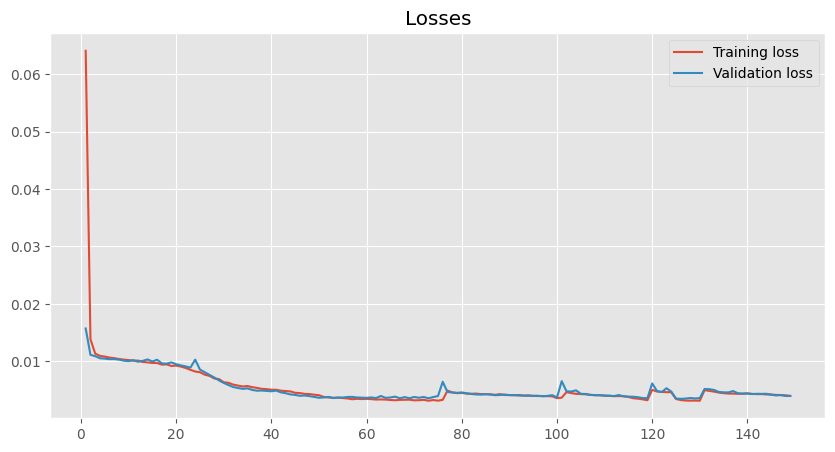

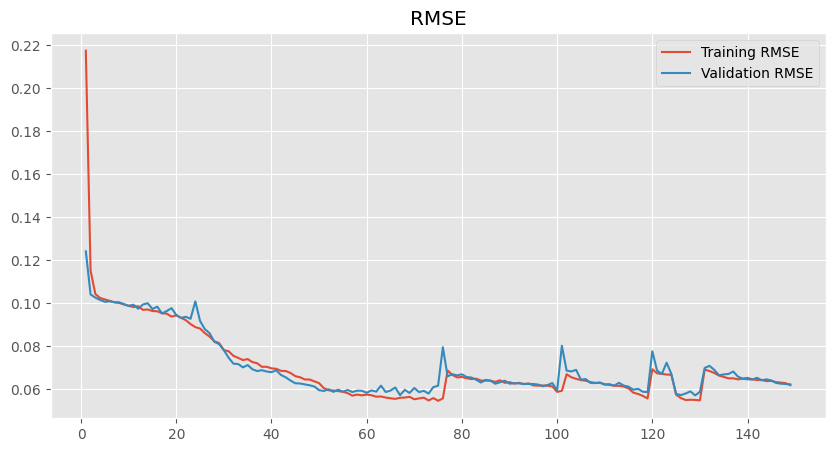

In [26]:
# perform training
num_epochs = 150
train_losses, val_losses, train_accs, val_accs, model = train_it( model, train_dataloader, val_dataloader, num_epochs)
# visualize losses
visualization(train_losses,val_losses,'loss')
visualization(train_accs,val_accs,'rmse')

The test function.

In [52]:
# predict values to test the model
def test_it( model, test_dloader, batch_sz):

	# initialize a list to store the forecasted values
	forecasted_values, real_values = [], []
	 
	model.eval()	
	with torch.no_grad():

		for X_batch_test, y_batch_test in test_dloader:
		
            #print(X_batch_test[0].size())
			#X_batch_test = X_batch_test.view([batch_size, -1, n_features]).to(device)
			X_batch_test = X_batch_test.to(device)
			y_batch_test = y_batch_test.to(device)

			y_forec = model(X_batch_test)

			y_forec = y_forec.cpu().data.numpy()
			y_test = y_batch_test.cpu().data.numpy()

			forecasted_values.append(y_forec)
			real_values.append(y_test)     


	return forecasted_values, real_values	


In [31]:
# xx, yy = next(iter(val_dataloader))
# print(xx.size())

# xx2 = next(iter(test_dataloader))
# print(xx2[0].size())

# #print(ts_seqs_test.unsqueeze(0).size())

Perform testing. Map the values of the forecasted and real/ground truth values back to their original value range and
plot them in the same figure for comparison purposes.

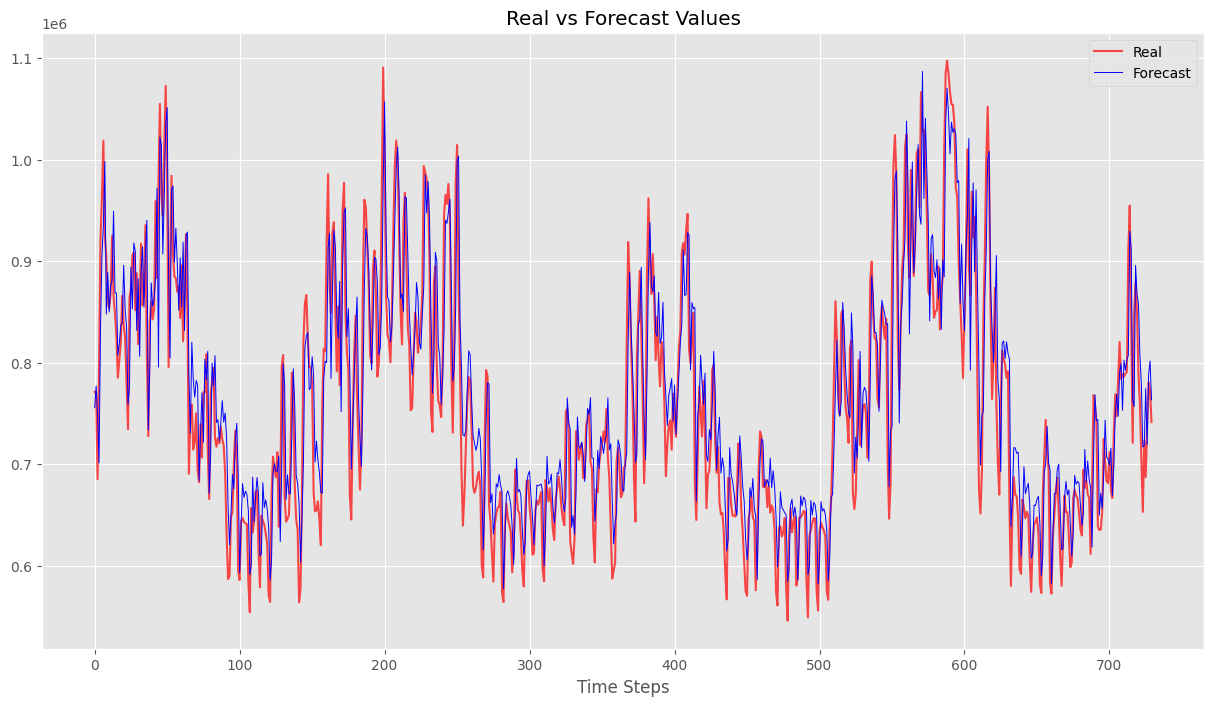

In [53]:
# perform testing
forecasted_values, real_values = test_it( model, test_dataloader, batch_size)
#forecasted_values = test_it( model, ts_seqs_test.unsqueeze(0), batch_size)

# convert predictions back to the original scale
forecasted_values = [ forv[0][0] for forv in forecasted_values ]
real_values = [ rv[0][0] for rv in real_values ]
forecasted_values = scaler.inverse_transform(np.array(forecasted_values).reshape(-1,1).tolist())
real_values = scaler.inverse_transform(np.array(real_values).reshape(-1,1).tolist())

plt.plot(real_values, color='red', alpha=0.7)
plt.plot(forecasted_values, color='blue', linewidth=0.7)
plt.title('Real vs Forecast Values')
plt.legend(['Real', 'Forecast'])
plt.xlabel('Time Steps')
plt.show()

In [54]:
# function to compute mean absolute error, mean squared error and mean absolute percentage error using sklearn metrics module
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

def compute_metrics( forecasted_values, real_values):

    metrics = {'mae' : mean_absolute_error(forecasted_values, real_values),
               'rmse' : mean_squared_error(forecasted_values, real_values) ** 0.5,
               'mape' : mean_absolute_percentage_error(forecasted_values, real_values)}
    
    return metrics

Compute and print MAE, RMSE and MAPE between real values and forecasted values using sklearn's metrics functions

In [55]:
# compute and print errors between real values and predicted values
metrics = compute_metrics( forecasted_values, real_values)
print("Mean Absolute Error: ", metrics["mae"])
print("Root Mean Squared Error: ", metrics["rmse"])
print("Mean Absolute Percentage Error: ", metrics["mape"])

Mean Absolute Error:  39687.81678835075
Root Mean Squared Error:  50353.70204375551
Mean Absolute Percentage Error:  0.05141847931564478




A better solution on this problem would be using instead of a RNN, Autoformer, a version of Transformer which seems to be state of the art in long time-series forecasting (https://arxiv.org/pdf/2106.13008.pdf). 